In [34]:
import torch

import numpy as np

from torch.utils.data import TensorDataset, DataLoader, Dataset

import torch.nn.functional as F

import pandas as pd

import os

import PIL.Image as image

import torch.nn as nn

from torchvision import transforms

import shutil

import random

import torchvision.models as models

import matplotlib.pyplot as plt
import copy
import time
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import cv2

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
class Imagedata(Dataset):

    def __init__(self,mode,path,transform):

      base_path =  path

      path = os.path.join(base_path,mode)

      self.images = []

      self.classlabels = []



      for idx,cls in enumerate(['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','spider','squirell']):

          raw_data = os.path.join(path,cls)



          files = os.listdir(raw_data)



          for im in files:

              self.images.append(os.path.join(raw_data,im))

              self.classlabels.append(idx)

              

      self.mytransform = transform #Compose([transforms.Resize(size=(224,224)),

                                               #transforms.ToTensor(),
                                              # transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])])

    def __len__(self):

        return len(self.images)

        

    def __getitem__(self,idx):



        Images = self.mytransform(image.open(self.images[idx]).convert('RGB'))

        labels = torch.tensor(self.classlabels[idx])



        return Images,labels


In [14]:
train_transforms = transforms.Compose([transforms.Resize(256),#change back to 256 or 232
                                                transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomRotation(degrees=15),
                                               transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                                transforms.ToTensor(),
                                               transforms.RandomResizedCrop(224),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])])

test_val_transforms = transforms.Compose([transforms.Resize(256),#change back to 256
                                            transforms.CenterCrop(224), #applied new transforms
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])])


In [15]:
train_data = []

test_data = []

val_data = []



datasets = [train_data,val_data,test_data] 

mode_dict = {'train':r"/kaggle/input/comp6721-projectdata/Processed_Data/Animals_10 data", 'validation':r"/kaggle/input/comp6721-projectdata/Processed_Data/Animals_10 data",'test':r"/kaggle/input/comp6721-projectdata/Processed_Data/Animals_10 data"}



for key, value in mode_dict.items():

    if key == 'train':

        train_data = Imagedata(key, value, train_transforms)

    elif key == 'validation':

        val_data = Imagedata(key, value, test_val_transforms)

    elif key == 'test':

        test_data = Imagedata(key,value,test_val_transforms)

In [16]:
def data_loader(train_data, test_data,val_data, batchsize):

    train_loader = DataLoader(train_data,batch_size=batchsize, shuffle=True)

    val_loader = DataLoader(val_data,batch_size=batchsize)

    test_loader = DataLoader(test_data,batch_size=batchsize)



    return train_loader, val_loader, test_loader

In [17]:
samples_per_batch = 64

train_loader, _ , _ = data_loader(train_data,test_data,val_data,batchsize = samples_per_batch)

_, val_loader, _ =  data_loader(train_data,test_data,val_data,batchsize = samples_per_batch)

_ , _ , test_loader =  data_loader(train_data,test_data,val_data,batchsize = samples_per_batch)

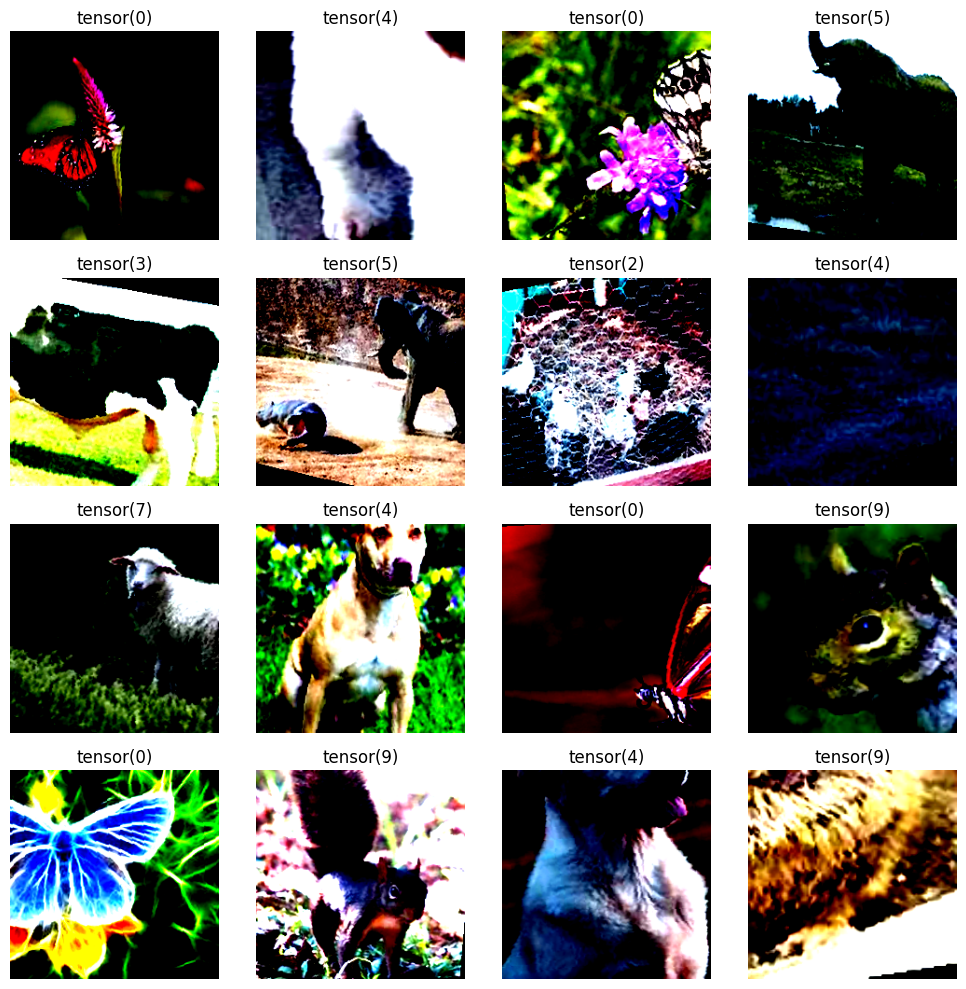

In [18]:
for data, labels in train_loader:
    pics_2use = data[:16,:,:,:]
    label = labels[:16]

    fig,axs = plt.subplots(4,4,figsize=(10,10))
    axs = axs.flatten()

    
    for i in range(16):
        axs[i].imshow(pics_2use[i].numpy().transpose(1,2,0)) 
        axs[i].axis('off')
        axs[i].set_title(label[i])
        
    plt.tight_layout()
    plt.show()
    break

In [19]:
#transfer-learning
restf_model = models.resnet18(weights=True)
mobtf_model = models.mobilenet_v3_small(weights=True)

In [20]:
res_num_features = restf_model.fc.in_features
restf_model.fc = nn.Linear(res_num_features,10)


mob_num_features = mobtf_model.classifier[3].in_features
mobtf_model.classifier[3] = nn.Linear(mob_num_features, 3)

In [21]:
for p in restf_model.parameters():
    p.requires_grad = False

for p in restf_model.fc.parameters():
    p.requires_grad = True

for p in mobtf_model.parameters():
    p.requires_grad = False

for p in mobtf_model.classifier[3].parameters():
    p.requires_grad = True

In [22]:
def train_model_resnet(input_model, epochs):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    best_model = None
    best_acc = 0
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(input_model.fc.parameters(), lr=0.01)
    input_model.to(device)

    for epoch in range(epochs):
        input_model.train()
        train_loss_sum = 0.0
        train_batches = 0
        train_preds = 0
        train_samps = 0
        for data,labels in train_loader:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            y_hat = input_model(data)
            loss = criterion(y_hat, labels)

            loss.backward()
            optimizer.step()

       
            predclass = torch.max(y_hat,1)
            train_samps += predclass[0].size(0)
            train_preds+=(predclass[1] == labels).sum()

            train_loss_sum += loss.item()
            train_batches += 1

        train_losses.append(train_loss_sum/train_batches)    
        acc_per_epoch = train_preds/train_samps *100
        train_acc.append(acc_per_epoch)
        

        input_model.eval()
        val_loss_sum = 0.0
        val_batches = 0
        val_samps = 0
        val_preds = 0
        with torch.no_grad():
            
            for data, labels in val_loader:
                data = data.to(device)
                labels = labels.to(device)
                preds = input_model(data)
                predClass = torch.max(preds,1)
                val_samps+=predClass[0].size(0)
                val_preds+=(predClass[1] == labels).sum()
                loss = criterion(preds,labels)
                val_loss_sum += loss.item()
                val_batches += 1

            val_losses.append(val_loss_sum/ val_batches)
                
            val_accuracy_per_epochs = val_preds/val_samps*100
            val_acc.append(val_accuracy_per_epochs)
            print(f"Epoch:{epoch}")
                
            current_validation_accuracy =  val_acc[-1]
            if current_validation_accuracy > best_acc:
                best_acc = current_validation_accuracy
                best_model = copy.deepcopy(input_model.state_dict())
        
        
    return train_losses, val_losses, train_acc, val_acc, best_model

In [23]:
model_1 = {'restransfer_model': restf_model}

results_1 = {}

no_of_epochs = 10

for model_name, model in model_1.items():

    train_loss, val_loss, train_acc, val_acc, net = train_model_resnet(model,no_of_epochs)

    results_1[model_name] = {

        'train_loss' : train_loss,

        'val_loss' : val_loss,

        'train_acc': train_acc,

        'val_acc': val_acc,

        'model' : net

    }

Epoch:0
Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8
Epoch:9


In [24]:
def plot_loss_and_accuracies_tf(loss_1,loss_2,acc_1,acc_2):
    loss_1 = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in loss_1]
    loss_2 = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in loss_2] 
    acc_1 = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in acc_1] 
    acc_2 = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in acc_2]

    fig,ax = plt.subplots(1,2,figsize=(16,5))

    ax[0].plot(loss_1,'s-',label='train')

    ax[0].plot(loss_2,'o-',label='validation')

    ax[0].set_ylabel('Loss')

    ax[0].set_xlabel('epoch')
    ax[0].legend()
    ax[0].grid(True)


    ax[1].plot(acc_1,'s-',label='train')

    ax[1].plot(acc_2,'o-',label='validation')

    ax[1].set_xlabel('epoch')

    ax[1].set_ylabel('Accuracy(%)')

    ax[1].grid(True)
    ax[1].legend()


In [25]:
restf_train_loss = results_1['restransfer_model']['train_loss']
restf_val_loss = results_1['restransfer_model']['val_loss']
restf_train_acc = results_1['restransfer_model']['train_acc']
restf_val_acc = results_1['restransfer_model']['val_acc']

In [27]:
print(restf_train_loss[-1])
print(restf_val_loss[-1])
print(restf_train_acc[-1])
print(restf_val_acc[-1])


0.6190888664396382
0.21890258914989805
tensor(84.6632, device='cuda:0')
tensor(94.7650, device='cuda:0')


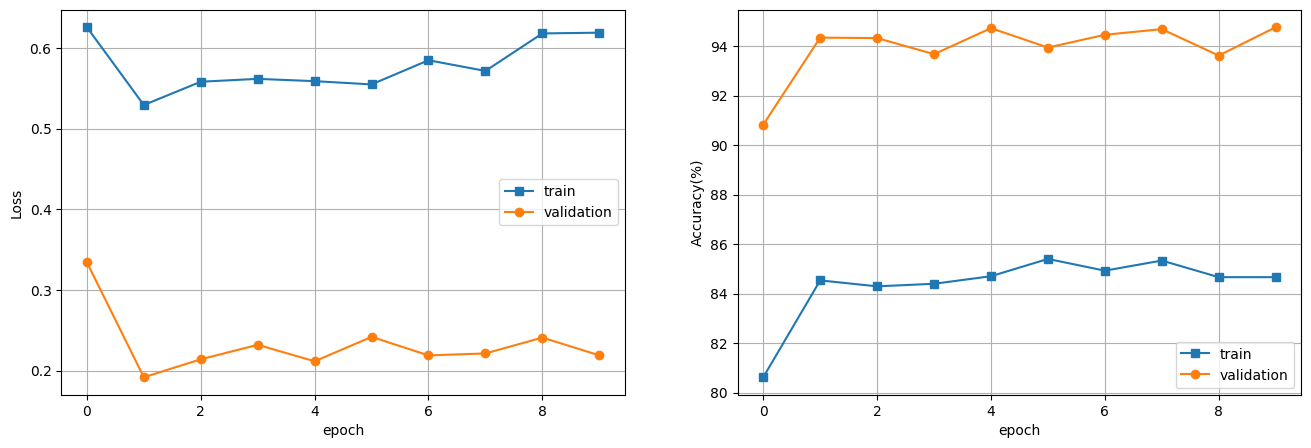

In [28]:
plot_loss_and_accuracies_tf(restf_train_loss,restf_val_loss,restf_train_acc,restf_val_acc)

In [30]:
trained_model = models.resnet18()
num_features = trained_model.fc.in_features
trained_model.fc = nn.Linear(num_features,10)


trained_model.load_state_dict(results_1['restransfer_model']['model'])

<All keys matched successfully>

In [31]:
def extract_image_features_plot(dataloader, model):
    model.eval()
    model.to(device)
    features = []
    labels = []
    with torch.no_grad():
        for images,lbls in dataloader:
            images = images.to(device)
            lbls = lbls.to(device)
                
            output = model(images)
            output = output.view(output.size(0),-1)
            features.append(output.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    plt.subplots(figsize=(10,8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:,1], c=labels, cmap ='viridis', s=50, alpha=0.5)
    plt.legend(*scatter.legend_elements())
    #plt.xlabel('t-sNE Component 1')
    #plt.ylabel('t-SNE Component2')
    plt.show()

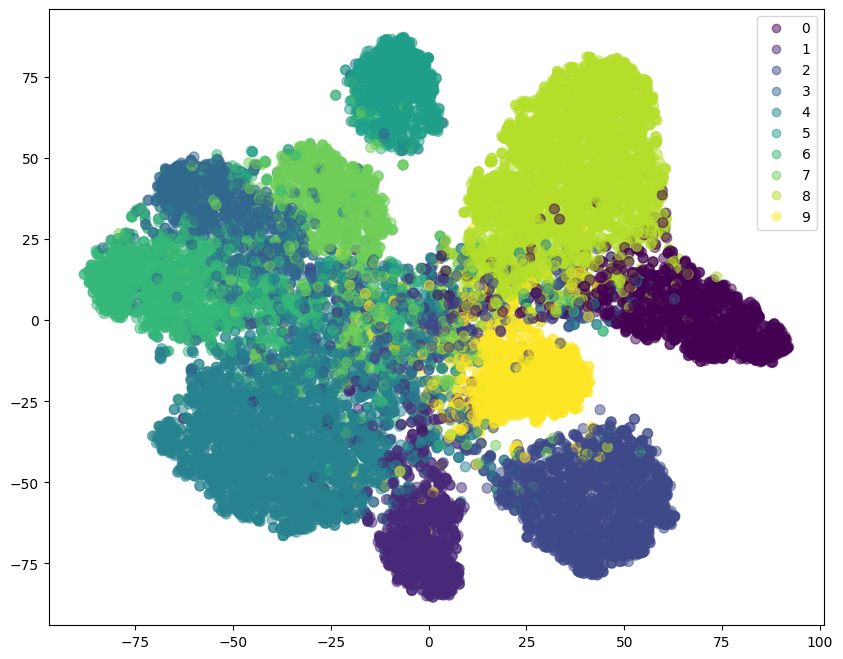

In [35]:
extract_image_features_plot(train_loader, trained_model)

In [36]:
test_loss = []
test_acc = []
num_epochs = 10
trained_model.to(device)
trained_model.eval()
for epoch in range(num_epochs):
    test_samps = 0
    test_preds = 0
    test_loss_sum = 0
    test_batches = 0

    with torch.no_grad():
        for data,labels in test_loader:  
            data = data.to(device)
            labels = labels.to(device)
            preds = trained_model(data)
            
            predClass = torch.max(preds,1)
            test_samps+=predClass[0].size(0)
            test_preds+=(predClass[1] == labels).sum()
            test_batches += 1 
    
        acc_per_epoch = (test_preds/test_samps) * 100
    
        
        #test_loss.append(test_loss_sum/ test_samps)
        test_acc.append(acc_per_epoch)

In [37]:
def test_loss_and_acc(acc):
    acc = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in acc]

    plt.plot(acc,'s-',label='test')

    plt.xlabel('no_of_batches')

    plt.ylabel('Accuracy(%)')

    plt.legend()

    plt.grid(True)


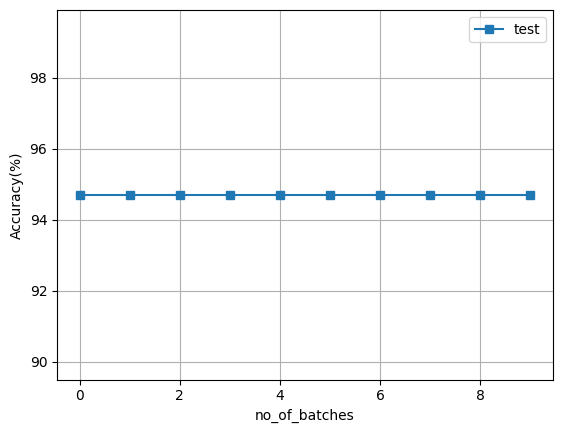

In [38]:
test_loss_and_acc(test_acc)

In [39]:
test_acc[-1]

tensor(94.7007, device='cuda:0')

In [46]:
def plot_classification_report_single_model(dataloader, model, device='cpu'):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report

    # Prepare the model for evaluation
    model.eval()
    model.to(device)

    y_true = []
    y_pred = []

    # Collect predictions and true labels
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            y_true.append(labels.cpu().numpy())

            outputs = model(images)
            preds = outputs.argmax(dim=1)
            y_pred.append(preds.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Calculate classification metrics
    report = classification_report(y_true, y_pred, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score', 'accuracy']
    report_data = []

    labels = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'

    for metric in metrics[:-1]:  # Precision, recall, f1-score
        average_metric_value = np.mean([report[label][metric] for label in labels if label not in ['accuracy', 'macro avg', 'weighted avg']])
        report_data.append(average_metric_value * 100)

    # Accuracy
    report_data.append(report['accuracy'] * 100)

    # Plot the bar chart
    x = np.arange(len(metrics))
    width = 0.6

    fig, ax = plt.subplots(figsize=(10, 6))
    color = '#1f77b4'  # Same color as before

    bars = ax.bar(x, report_data, width, color=color)

    # Annotate bars with metric values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores (%)')
   # ax.set_title('Classification Metrics for Single Model')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)

    plt.tight_layout()
    plt.show()


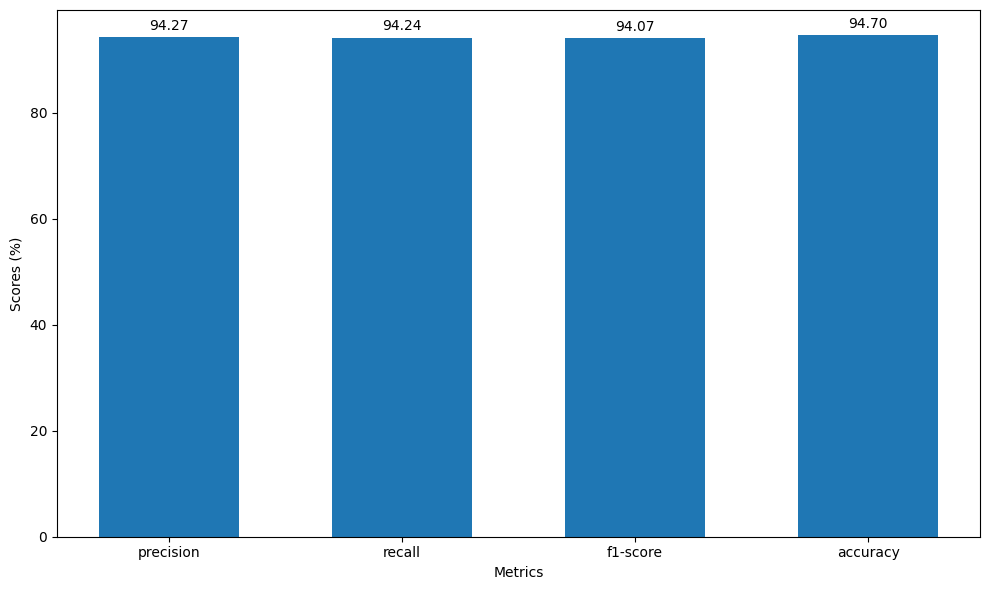

In [49]:
model_dict = {
    'ResNet18_transferlearning': trained_model
}

plot_classification_report_single_model(test_loader, trained_model)

In [50]:
class Imagedata2(Dataset):

    def __init__(self,mode,path,transform):

      base_path =  path

      path = os.path.join(base_path,mode)

      self.images = []

      self.classlabels = []



      for idx,cls in enumerate(['bee','unrelated_insects','wasp']):

          raw_data = os.path.join(path,cls)



          files = os.listdir(raw_data)



          for im in files:

              self.images.append(os.path.join(raw_data,im))

              self.classlabels.append(idx)

              

      self.mytransform = transform

    def __len__(self):

        return len(self.images)

        

    def __getitem__(self,idx):



        Images = self.mytransform(image.open(self.images[idx]).convert('RGB'))

        labels = torch.tensor(self.classlabels[idx])



        return Images,labels

In [51]:
train_data = []

test_data = []

val_data = []



datasets = [train_data,val_data,test_data] 

mode_dict = {'train_set':r"/kaggle/input/comp6721-projectdata/Processed_Data/Bee_Wasp_Other Insect data", 'val_set':r"/kaggle/input/comp6721-projectdata/Processed_Data/Bee_Wasp_Other Insect data",'test_set':r"/kaggle/input/comp6721-projectdata/Processed_Data/Bee_Wasp_Other Insect data"}



for key, value in mode_dict.items():


    if key == 'train_set':

        train_data = Imagedata2(key,value, train_transforms)

    elif key == 'val_set':

        val_data = Imagedata2(key,value, test_val_transforms)

    elif key == 'test_set':

        test_data = Imagedata2(key,value, test_val_transforms)

In [52]:
def data_loader(train_data, test_data,val_data, batchsize):

    train_loader = DataLoader(train_data,batch_size=batchsize, shuffle=True)

    val_loader = DataLoader(val_data,batch_size=batchsize)

    test_loader = DataLoader(test_data,batch_size=batchsize)



    return train_loader, val_loader, test_loader

In [53]:
samples_per_batch = 64

train_loader, _ , _ = data_loader(train_data,test_data,val_data,batchsize = samples_per_batch)

_, val_loader, _ =  data_loader(train_data,test_data,val_data,batchsize = samples_per_batch)

_ , _ , test_loader =  data_loader(train_data,test_data,val_data,batchsize = samples_per_batch)

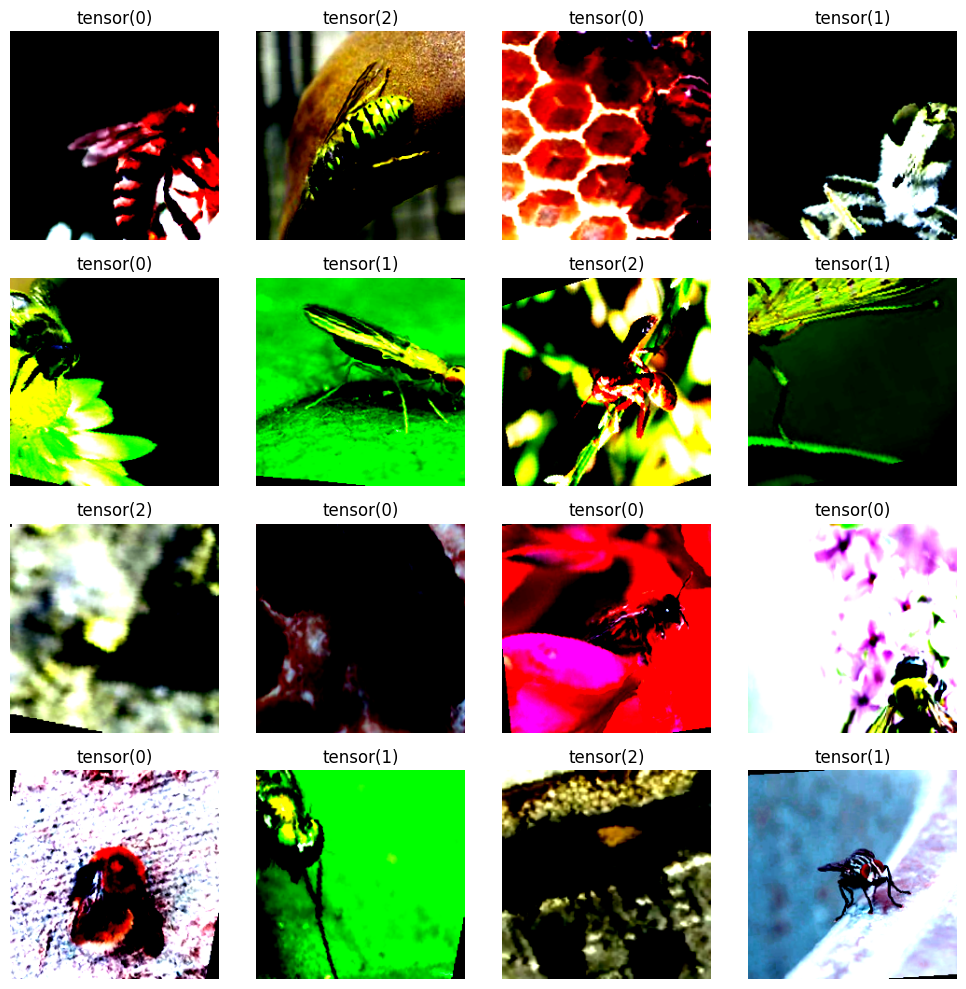

In [54]:
for data, labels in train_loader:
    pics_2use = data[:16,:,:,:]
    label = labels[:16]

    fig,axs = plt.subplots(4,4,figsize=(10,10))
    axs = axs.flatten()

    
    for i in range(16):
        axs[i].imshow(pics_2use[i].numpy().transpose(1,2,0)) 
        axs[i].axis('off')
        axs[i].set_title(label[i])
        
    plt.tight_layout()
    plt.show()
    break

In [55]:
def train_model_mobile(input_model, epochs):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    best_model = None
    best_acc = 0
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(input_model.classifier[3].parameters(), lr=0.001)
    input_model.to(device)

    for epoch in range(epochs):
        input_model.train()
        train_loss_sum = 0.0
        train_batches = 0
        train_preds = 0
        train_samps = 0
        for data,labels in train_loader:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            y_hat = input_model(data)
            loss = criterion(y_hat, labels)

            loss.backward()
            optimizer.step()

       
            predclass = torch.max(y_hat,1)
            train_samps += predclass[0].size(0)
            train_preds+=(predclass[1] == labels).sum()

            train_loss_sum += loss.item()
            train_batches += 1

        train_losses.append(train_loss_sum/train_batches)    
        acc_per_epoch = train_preds/train_samps *100
        train_acc.append(acc_per_epoch)
        

        input_model.eval()
        val_loss_sum = 0.0
        val_batches = 0
        val_samps = 0
        val_preds = 0
        with torch.no_grad():
            
            for data, labels in val_loader:
                data = data.to(device)
                labels = labels.to(device)
                preds = input_model(data)
                predClass = torch.max(preds,1)
                val_samps+=predClass[0].size(0)
                val_preds+=(predClass[1] == labels).sum()
                loss = criterion(preds,labels)
                val_loss_sum += loss.item()
                val_batches += 1

            val_losses.append(val_loss_sum/ val_batches)
                
            val_accuracy_per_epochs = val_preds/val_samps*100
            val_acc.append(val_accuracy_per_epochs)
            print(f"Epoch:{epoch}")
                
            current_validation_accuracy =  val_acc[-1]
            if current_validation_accuracy > best_acc:
                best_acc = current_validation_accuracy
                best_model = copy.deepcopy(input_model.state_dict())
        
        
    return train_losses, val_losses, train_acc, val_acc, best_model

In [57]:
model2 = {'mobtransfer_model':mobtf_model}

results2 = {}

no_of_epochs = 10

for model_name, model in model2.items():

    train_loss, val_loss, train_acc, val_acc, net = train_model_mobile(model,no_of_epochs)

    results2[model_name] = {

        'train_loss' : train_loss,

        'val_loss' : val_loss,

        'train_acc': train_acc,

        'val_acc': val_acc,

        'model' : net

    }

Epoch:0
Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8
Epoch:9


In [58]:
mobtf_train_loss = results2['mobtransfer_model']['train_loss']
mobtf_val_loss = results2['mobtransfer_model']['val_loss']
mobtf_train_acc = results2['mobtransfer_model']['train_acc']
mobtf_val_acc = results2['mobtransfer_model']['val_acc']

In [60]:
print(mobtf_train_loss[-1])
print(mobtf_val_loss[-1])
print(mobtf_train_acc[-1])
print(mobtf_val_acc[-1])

0.41127012522868167
0.3273305329291717
tensor(83.8634, device='cuda:0')
tensor(87.4403, device='cuda:0')


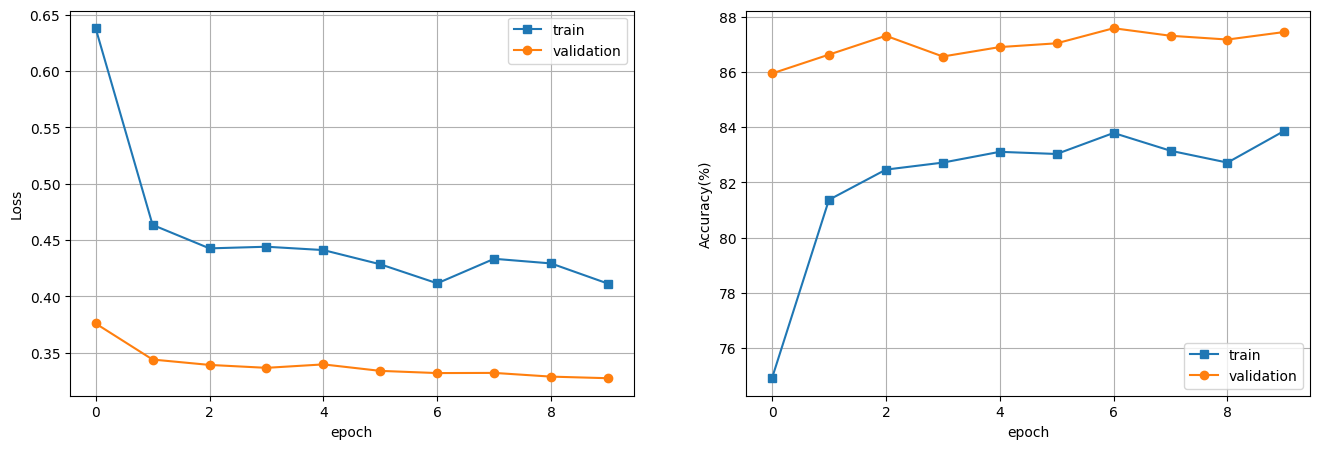

In [62]:
plot_loss_and_accuracies_tf(mobtf_train_loss,mobtf_val_loss,mobtf_train_acc,mobtf_val_acc)

In [64]:
trained_model2 = models.mobilenet_v3_small()
num_features = trained_model2.classifier[3].in_features
trained_model2.classifier[3] = nn.Linear(num_features,3)

trained_model2.load_state_dict(results2['mobtransfer_model']['model'])

<All keys matched successfully>

In [65]:
test_loss = []
mobtest_acc = []
num_epochs = 10
trained_model2.to(device)
trained_model2.eval()
for epoch in range(num_epochs):
    test_samps = 0
    test_preds = 0
    test_loss_sum = 0
    test_batches = 0

    with torch.no_grad():
        for data,labels in test_loader:  
            data = data.to(device)
            labels = labels.to(device)
            preds = trained_model2(data)
            
            predClass = torch.max(preds,1)
            test_samps+=predClass[0].size(0)
            test_preds+=(predClass[1] == labels).sum()
            
            test_batches += 1 
    
        acc_per_epoch = (test_preds/test_samps) * 100
    
        mobtest_acc.append(acc_per_epoch)

In [66]:
def plot_test_acc(acc):
    acc = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in acc]

    plt.plot(acc,'s-',label='test')

    plt.xlabel('no_of_batches')

    plt.ylabel('Accuracy(%)')

    plt.legend()

    plt.grid(True)


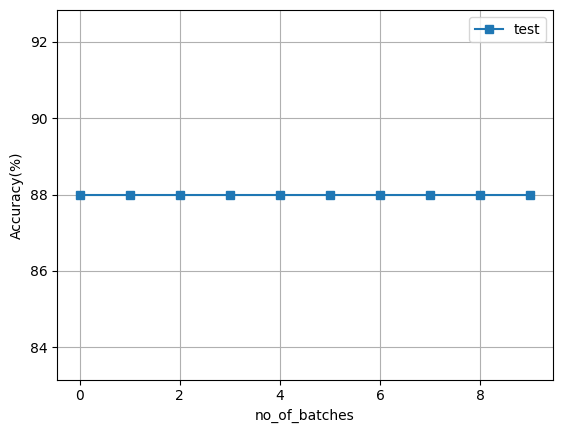

In [67]:
plot_test_acc(mobtest_acc)

In [68]:
mobtest_acc[-1]

tensor(87.9945, device='cuda:0')

In [69]:
def extract_image_features_plot(dataloader, model):
    model.eval()
    model.to(device)
    features = []
    labels = []
    with torch.no_grad():
        for images,lbls in dataloader:
            images = images.to(device)
            lbls = lbls.to(device)
                
            output = model(images)
            output = output.view(output.size(0),-1)
            features.append(output.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    plt.subplots(figsize=(10,8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:,1], c=labels, cmap ='viridis', s=50, alpha=0.5)
    plt.legend(*scatter.legend_elements())
    #plt.xlabel('t-sNE Component 1')
    #plt.ylabel('t-SNE Component2')
    plt.show()

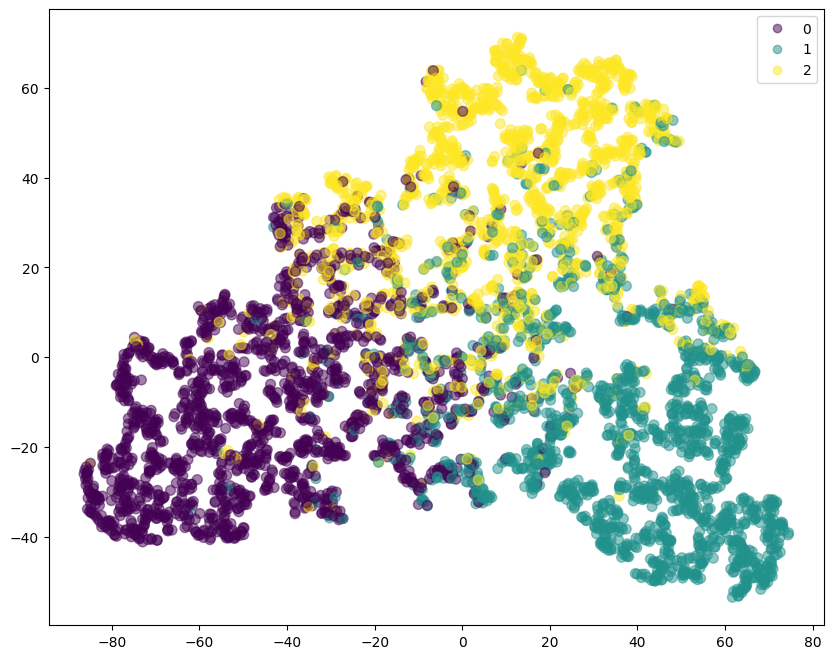

In [70]:
extract_image_features_plot(train_loader, trained_model2)

In [71]:
def plot_classification_report_single_model(dataloader, model, device='cpu'):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report

    # Prepare the model for evaluation
    model.eval()
    model.to(device)

    y_true = []
    y_pred = []

    # Collect predictions and true labels
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            y_true.append(labels.cpu().numpy())

            outputs = model(images)
            preds = outputs.argmax(dim=1)
            y_pred.append(preds.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Calculate classification metrics
    report = classification_report(y_true, y_pred, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score', 'accuracy']
    report_data = []

    labels = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'

    for metric in metrics[:-1]:  # Precision, recall, f1-score
        average_metric_value = np.mean([report[label][metric] for label in labels if label not in ['accuracy', 'macro avg', 'weighted avg']])
        report_data.append(average_metric_value * 100)

    # Accuracy
    report_data.append(report['accuracy'] * 100)

    # Plot the bar chart
    x = np.arange(len(metrics))
    width = 0.6

    fig, ax = plt.subplots(figsize=(10, 6))
    color = '#1f77b4'  # Same color as before

    bars = ax.bar(x, report_data, width, color=color)

    # Annotate bars with metric values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores (%)')
   # ax.set_title('Classification Metrics for Single Model')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)

    plt.tight_layout()
    plt.show()


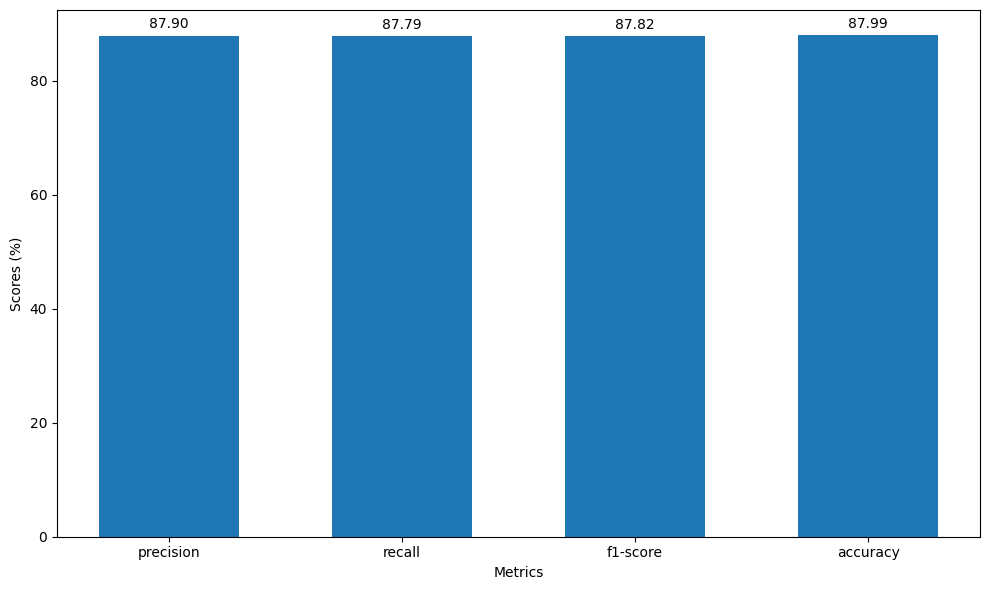

In [72]:
plot_classification_report_single_model(test_loader, trained_model2)